# Project: Lightweight Hybrid Model for Sensor Event Classification (Channel-as-Sample)

Training a **lightweight** hybrid model using spectrograms and statistical features to classify sensor data into Steps, Vehicle, or Noise. This version treats **each sensor channel from multi-channel files as an independent sample** to increase dataset size. It uses MobileNetV3-Small for reduced computational cost, aiming for potential real-time application.

#1

In [4]:
# --- Core Libraries ---
import numpy as np
import pandas as pd
import os
import glob
import time
import random
from copy import deepcopy
import pickle
import warnings

# --- PyTorch Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# <<< שינוי: ייבוא מודל קל יותר >>>
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Scikit-learn & Imblearn Libraries ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# --- Signal Processing & Feature Extraction ---
from scipy.signal import butter, filtfilt, spectrogram
import librosa

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # <<< ודא שזה מיובא

# --- Configuration ---
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 3)

## Global Settings & Parameters

Define constants, paths, labels, processing parameters, and hyperparameters. **Note:** `max_channels` is no longer relevant as we treat each channel separately.

#2

In [2]:
# ======================== Device ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = min(4, os.cpu_count()) if device.type == 'cuda' else 0
print(f"Device: {device}, Workers: {num_workers}")

# ======================== Labels ========================
LABEL_STEPS    = 0; LABEL_VEHICLE  = 1; LABEL_NOISE    = 2
CLASS_NAMES    = ["Steps", "Vehicle", "Noise"]; NUM_CLASSES    = len(CLASS_NAMES)
print(f"Classes: {CLASS_NAMES}")

# ================= Signal Processing ==================
window_size    = 2000; fs = 1000.0; stride = 250
# max_channels   = 37 # <<< לא רלוונטי יותר
lowcut = 1.0; highcut = 100.0; order = 4

# ================= Feature Extraction =================
NUM_BASE_FEATURES = 8; NUM_MFCC_FEATURES = 13
NUM_STAT_FEATURES = NUM_BASE_FEATURES + NUM_MFCC_FEATURES # 21
N_FFT = 512; HOP_LENGTH = N_FFT // 4; IMG_HEIGHT = 224; IMG_WIDTH = 224

# ===================== File Paths =====================
BASE_DIR = "."
DATA_DIR = os.path.join(BASE_DIR, "data")
# --- Define the input files directly ---
# <<< שימוש רק בסט המקורי שהוגדר >>>
INPUT_FILES_LABELS = {
    # File Basename : Label
    "man.csv": LABEL_STEPS,
    "car.csv": LABEL_VEHICLE,
    "car2.csv": LABEL_VEHICLE,
    "car3.csv": LABEL_VEHICLE,
    "car4.csv": LABEL_VEHICLE,
    "noise.csv": LABEL_NOISE,
    "nothing.csv": LABEL_NOISE,
}

# ================== Train/Val Split ===================
VALIDATION_SPLIT_RATIO = 0.20 # 20% for validation
STRATIFY_SEED = 42 # Seed for reproducible splitting

# ===================== Output Path ====================
RUN_NAME = f"light_model_channel_as_sample_{time.strftime('%Y%m%d_%H%M%S')}" # שם חדש לריצה
SAVE_PATH_BASE = os.path.join(BASE_DIR, "saved_models", RUN_NAME)
os.makedirs(SAVE_PATH_BASE, exist_ok=True)
print(f"Output Path: {SAVE_PATH_BASE}")

# =================== Hyperparameters ==================
# <<< שימוש באותם היפר-פרמטרים כנקודת התחלה, ייתכן שיצטרכו כוונון מחדש >>>
BEST_PARAMS = {
    "lr": 0.0009025320915332941,"weight_decay": 0.00010440037020653871,
    "dropout_p": 0.4, # <<< אולי נוריד מעט דרופאאוט למודל קל יותר? (אופציונלי)
    "stat_dim": 64, # <<< אולי נקטין מעט את ה-MLP? (אופציונלי)
    "comb_dim": 128, # <<< אולי נקטין מעט? (אופציונלי)
    "specaug_apply": False, "specaug_freq_mask": 35,"specaug_time_mask": 92,
    "specaug_f_masks": 2,"specaug_t_masks": 3,"add_stat_noise": False,
    "stat_feature_noise_std": 0.11978948454559124,"label_smoothing": 7.290046944521044e-06
}
FINAL_EPOCHS = 150; FINAL_PATIENCE = 20; FINAL_BATCH_SIZE = 32 # <<< אולי נצטרך פחות אפוקים/פחות סבלנות
SCHEDULER_PATIENCE = max(1, FINAL_PATIENCE // 3); SCHEDULER_FACTOR = 0.2
print(f"Batch Size: {FINAL_BATCH_SIZE}, Epochs: {FINAL_EPOCHS}, Patience: {FINAL_PATIENCE}")

Device: cuda, Workers: 4
Classes: ['Steps', 'Vehicle', 'Noise']
Output Path: .\saved_models\light_model_channel_as_sample_20250401_110416
Batch Size: 32, Epochs: 150, Patience: 20


🛠️ ## Helper Functions

Contains functions for data processing, feature extraction, model definition, training, evaluation, and visualization. **Note:** `pad_channels` is removed. Model definition uses MobileNetV3-Small.

#3

In [10]:
# =====================================================================================
# =                           Data Preprocessing Functions                           =
# =====================================================================================

# def pad_channels(...): # <<< הפונקציה הזו הוסרה - לא רלוונטית יותר

def create_windows(signal_1d, label, window_size=window_size, stride=stride):
    """Creates overlapping windows from a 1D signal."""
    # Ensure input is 1D or (N, 1)
    if signal_1d.ndim > 1 and signal_1d.shape[1] != 1:
        print(f"  Warning: create_windows expected 1D signal, got shape {signal_1d.shape}. Using first column.")
        signal_1d = signal_1d[:, 0]
    signal_1d = signal_1d.flatten() # Make sure it's purely 1D

    X_windows, y_labels = [], []
    if len(signal_1d) < window_size: return [], []
    for start in range(0, len(signal_1d) - window_size + 1, stride):
        window = signal_1d[start : start + window_size] # החלון הוא 1D
        X_windows.append(window)
        y_labels.append(label)
    return X_windows, y_labels

def apply_filter(data_1d, lowcut=lowcut, highcut=highcut, fs=fs, order=order):
    """Applies a Butterworth bandpass filter to a 1D signal."""
    data_1d = data_1d.flatten() # Ensure 1D
    try:
        nyquist = 0.5 * fs; low = max(lowcut / nyquist, 1e-6); high = min(highcut / nyquist, 1.0 - 1e-6)
        if low >= high: return data_1d
        b, a = butter(order, [low, high], btype='band')
        if len(data_1d) <= order * 3: return data_1d
        return filtfilt(b, a, data_1d, axis=0)
    except Exception as e: return data_1d

# =====================================================================================
# =                         Feature Extraction Functions                             =
# =====================================================================================
# (create_stft_spectrogram, extract_statistical_features נשארות זהות - הן כבר עובדות על 1D)
def create_stft_spectrogram(signal_1d, sr=fs, n_fft=N_FFT, hop_length=HOP_LENGTH, lowcut_spec=lowcut, highcut_spec=highcut):
    try:
        signal_float = signal_1d.astype(np.float32); f, t, Sxx = spectrogram(signal_float, fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length, nfft=n_fft)
        freq_idx = np.where((f >= lowcut_spec) & (f <= highcut_spec))[0];
        if len(freq_idx) == 0: return None
        Sxx_band = Sxx[freq_idx, :]; Sxx_db = 10 * np.log10(Sxx_band + 1e-9); min_db, max_db = np.min(Sxx_db), np.max(Sxx_db)
        if max_db - min_db < 1e-9: return np.zeros_like(Sxx_db, dtype=np.float32)
        Sxx_norm = (Sxx_db - min_db) / (max_db - min_db); return Sxx_norm.astype(np.float32)
    except Exception as e: return None

def extract_statistical_features(signal_1d, sr=fs, n_mfcc=NUM_MFCC_FEATURES):
    try:
        signal_float = signal_1d.astype(np.float32); features = []
        features.extend([np.mean(signal_float), np.std(signal_float), np.sqrt(np.mean(signal_float**2))]); features.append(np.mean(librosa.feature.zero_crossing_rate(y=signal_float)))
        stft_result = librosa.stft(signal_float, n_fft=N_FFT, hop_length=HOP_LENGTH); spec_mag = np.abs(stft_result)
        features.append(np.mean(librosa.feature.spectral_centroid(S=spec_mag, sr=sr))); features.append(np.mean(librosa.feature.spectral_bandwidth(S=spec_mag, sr=sr)))
        features.append(np.mean(librosa.feature.spectral_rolloff(S=spec_mag, sr=sr, roll_percent=0.85))); features.append(np.mean(librosa.feature.spectral_flatness(S=spec_mag)))
        mfccs_feats = librosa.feature.mfcc(y=signal_float, sr=sr, n_mfcc=n_mfcc); mfccs_mean = np.mean(mfccs_feats, axis=1)
        if mfccs_mean.shape[0] < n_mfcc: mfccs_mean = np.pad(mfccs_mean, (0, n_mfcc - mfccs_mean.shape[0]), mode='constant')
        elif mfccs_mean.shape[0] > n_mfcc: mfccs_mean = mfccs_mean[:n_mfcc]
        features.extend(mfccs_mean); final_features = np.array(features, dtype=np.float32)
        if final_features.shape[0] != NUM_STAT_FEATURES: final_features = np.pad(final_features, (0, NUM_STAT_FEATURES - final_features.shape[0]), mode='constant')[:NUM_STAT_FEATURES]
        if np.isnan(final_features).any() or np.isinf(final_features).any(): final_features = np.nan_to_num(final_features, nan=0.0, posinf=0.0, neginf=0.0)
        return final_features
    except Exception as e: return np.zeros(NUM_STAT_FEATURES, dtype=np.float32)

# =====================================================================================
# =                 PyTorch Dataset, Augmentation, and Model Classes               =
# =====================================================================================
# (SpecAugment, HybridDataset נשארים זהים)
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param=10, time_mask_param=20, num_freq_masks=1, num_time_masks=1): super().__init__(); self.freq_mask_param=freq_mask_param; self.time_mask_param=time_mask_param; self.num_freq_masks=num_freq_masks; self.num_time_masks=num_time_masks
    def forward(self, spec):
        if not isinstance(spec, torch.Tensor): raise TypeError("Tensor"); spec_aug=spec.clone(); _,F,T=spec_aug.shape
        for _ in range(self.num_freq_masks): f=random.randrange(0,self.freq_mask_param+1); f0=random.randrange(0,F-f+1) if F>f else 0; spec_aug[:,f0:f0+f,:]=spec_aug.mean()
        for _ in range(self.num_time_masks): t=random.randrange(0,self.time_mask_param+1); t0=random.randrange(0,T-t+1) if T>t else 0; spec_aug[:,:,t0:t0+t]=spec_aug.mean()
        return spec_aug

class HybridDataset(Dataset):
    def __init__(self, specs, stat_feats, labels, transform=None, add_noise=False, noise_std=0.01):
        self.specs=np.asarray(specs,dtype=np.float32); self.stat_feats=np.asarray(stat_feats,dtype=np.float32); self.labels=np.asarray(labels,dtype=np.int64); self.transform=transform; self.add_noise=add_noise; self.noise_std=noise_std
        assert len(self.specs)==len(self.stat_feats)==len(self.labels),"Data length mismatch";
        if len(self.stat_feats)>0: assert self.stat_feats.shape[1]==NUM_STAT_FEATURES,f"Stat features dim mismatch: Got {self.stat_feats.shape[1]}"
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        spec=self.specs[idx]; stat_feat_orig=self.stat_feats[idx]; label=self.labels[idx]
        if self.add_noise and self.noise_std>0: noise=np.random.normal(0,self.noise_std,size=stat_feat_orig.shape); stat_feat=stat_feat_orig+noise.astype(stat_feat_orig.dtype)
        else: stat_feat=stat_feat_orig
        spec_tensor=torch.tensor(spec,dtype=torch.float32);
        if self.transform: spec_tensor=self.transform(spec_tensor)
        stat_tensor=torch.tensor(stat_feat,dtype=torch.float32); label_tensor=torch.tensor(label,dtype=torch.long); return spec_tensor,stat_tensor,label_tensor

# <<< שינוי: שימוש במודל קל יותר >>>
class LightweightHybridModel(nn.Module):
    """Hybrid Model combining MobileNetV3-Small for Spectrograms and MLP for Stats."""
    def __init__(self, num_classes=NUM_CLASSES, dropout_p=0.3, # אולי דרופאאוט נמוך יותר
                 input_stat_features=NUM_STAT_FEATURES, stat_feature_dim=64, combined_dim=128):
        super().__init__()
        # --- CNN Backbone (MobileNetV3-Small) ---
        weights = MobileNet_V3_Small_Weights.DEFAULT
        self.cnn_backbone = mobilenet_v3_small(weights=weights)
        # Get the number of output features from MobileNetV3-Small's standard classifier
        try:
            # Structure is typically: Sequential(Linear(in=576, out=1024), Hardswish(), Dropout(), Linear(in=1024, out=1000))
            # We need the input features to the first Linear layer in the classifier sequence
            cnn_out_features = self.cnn_backbone.classifier[0].in_features # Should be 576
            print(f"MobileNetV3-Small classifier input features: {cnn_out_features}")
        except Exception as e:
            print(f"Warning: Could not automatically determine MobileNetV3-Small output features ({e}). Assuming 576.")
            cnn_out_features = 576
        # Remove the original classification head
        self.cnn_backbone.classifier = nn.Identity()

        # --- MLP for Statistical Features ---
        self.stat_mlp = nn.Sequential(
            nn.LayerNorm(input_stat_features),
            nn.Linear(input_stat_features, stat_feature_dim * 2), nn.ReLU(), nn.Dropout(dropout_p),
            nn.Linear(stat_feature_dim * 2, stat_feature_dim), nn.ReLU()
        )
        # --- Combined Classifier ---
        self.dropout = nn.Dropout(dropout_p)
        self.fc_combined = nn.Linear(cnn_out_features + stat_feature_dim, combined_dim)
        self.fc_output = nn.Linear(combined_dim, num_classes)

    def forward(self, spec_input, stat_input):
        cnn_features = self.cnn_backbone(spec_input)
        stat_features = self.stat_mlp(stat_input)
        combined = torch.cat((cnn_features, stat_features), dim=1)
        x = self.dropout(combined); x = F.relu(self.fc_combined(x)); x = self.dropout(x)
        out = self.fc_output(x); return out

# =====================================================================================
# =                   Training, Evaluation & Utility Functions                       =
# =====================================================================================

def plot_split_counts(labels, title, ax):
    """Helper function to plot class counts for train/val splits."""
    if len(labels) == 0:
        ax.set_title(f"{title}\n(No Data)")
        ax.set_xticks([])
        ax.set_yticks([])
        return

    counts = np.bincount(labels, minlength=NUM_CLASSES)
    colors = plt.cm.Paired.colors[:NUM_CLASSES] # Use a color palette

    bars = ax.bar(CLASS_NAMES, counts, color=colors)
    ax.set_title(title)
    ax.set_ylabel("Number of Signals") # Or "Number of Windows" depending on context
    ax.bar_label(bars, padding=3) # Add counts on top
    ax.margins(y=0.1) # Add some margin above bars
def train_epoch_hybrid(model, dataloader, criterion, optimizer, device):
    """Trains the hybrid model for one epoch."""
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (specs, stat_feats, labels) in enumerate(dataloader):
        # Move data to the appropriate device
        specs, stat_feats, labels = specs.to(device), stat_feats.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        try:
            outputs = model(specs, stat_feats)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item() * labels.size(0) # Accumulate loss scaled by batch size
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        except Exception as e:
            print(f"Error training batch {batch_idx}: {e}")
            # Optional: skip batch or try to recover
            # torch.cuda.empty_cache() # If CUDA error
            continue # Skip to next batch

    # Calculate epoch metrics
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc

@torch.no_grad() # Disable gradient calculation for evaluation
def evaluate_model_hybrid(model, dataloader, criterion, device, is_final_eval=False):
    """Evaluates the hybrid model on a given dataset."""
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    for specs, stat_feats, labels in dataloader:
        specs, stat_feats, labels = specs.to(device), stat_feats.to(device), labels.to(device)

        try:
            outputs = model(specs, stat_feats)

            # Calculate loss only if criterion is provided (e.g., during validation)
            if not is_final_eval and criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)

            # Calculate predictions
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Store labels and predictions for later analysis (like confusion matrix)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        except Exception as e: # <<< בלוק except שמתאים ל-try הפנימי
            print(f"Error evaluating batch: {e}")
            continue

    # חישובים אחרי הלולאה
    epoch_loss = running_loss / total_samples if total_samples > 0 and not is_final_eval else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)


def save_final_model(epoch, model, optimizer, scaler, val_loss, val_acc, params, filename):
    """Saves the model checkpoint."""
    print(f"\nSaving checkpoint to {filename} (Epoch {epoch}, ValLoss {val_loss:.4f}, ValAcc {val_acc:.4f})")
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_params': { # Store scaler attributes for later use
            'mean': scaler.mean_,
            'scale': scaler.scale_,
            'n_features': scaler.n_features_in_,
            'n_samples': scaler.n_samples_seen_,
        },
        'val_loss': val_loss,
        'val_acc': val_acc,
        'best_optuna_params': params, # Store the hyperparameters used
        'fs': fs, # Store relevant processing params
        'window_size': window_size,
        'stride': stride,
        # 'max_channels': max_channels, # לא רלוונטי יותר
        'num_stat_features': NUM_STAT_FEATURES,
    }
    try:
        torch.save(state, filename)
    except Exception as e:
        print(f"Error saving checkpoint: {e}")


def plot_training_history(history, save_dir, prefix=""):
    """Plots and saves the training/validation loss and accuracy curves."""
    history_path = os.path.join(save_dir, f"{prefix}train_history.png")
    print(f"\nSaving training history plot to {history_path}")

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 4)) # גודל סביר לגרף

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss', markersize=4)
    if 'val_loss' in history and any(x is not None for x in history['val_loss']):
         plt.plot(epochs, [l if l is not None else np.nan for l in history['val_loss']], 'ro--', label='Validation Loss', markersize=4)
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle=':') # רשת קווים קלה יותר

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy', markersize=4)
    if 'val_acc' in history and any(x is not None for x in history['val_acc']):
        plt.plot(epochs, [a if a is not None else np.nan for a in history['val_acc']], 'ro--', label='Validation Accuracy', markersize=4)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(bottom=0.0, top=1.05)
    plt.legend()
    plt.grid(True, linestyle=':')

    plt.tight_layout()
    try:
        plt.savefig(history_path)
        plt.close() # Close the plot to free memory
    except Exception as e:
        print(f"Error saving history plot: {e}")
        plt.close()


def display_results(true_labels, pred_labels, dataset_name, save_dir=".", prefix="", class_names=CLASS_NAMES):
    """Calculates, prints, and plots evaluation metrics."""
    print(f"\n--- Results: {dataset_name} ---")

    # Input validation
    if not isinstance(true_labels, (list, np.ndarray)) or not isinstance(pred_labels, (list, np.ndarray)): print("Invalid input type."); return
    if len(true_labels) == 0 or len(pred_labels) == 0: print("Empty inputs."); return
    if len(true_labels) != len(pred_labels): print("Length mismatch."); return
    try:
        true_labels_int = np.asarray(true_labels).astype(int)
        pred_labels_int = np.asarray(pred_labels).astype(int)
    except ValueError: print("Cannot convert labels to integers."); return

    try:
        accuracy = accuracy_score(true_labels_int, pred_labels_int)
        print(f"Accuracy: {accuracy:.4f}")

        # Classification Report
        print("\nClassification Report:")
        target_labels = list(range(len(class_names)))
        report = classification_report(true_labels_int, pred_labels_int, target_names=class_names, labels=target_labels, zero_division=0)
        print(report)

        # Confusion Matrix
        print("\nConfusion Matrix:")
        cm = confusion_matrix(true_labels_int, pred_labels_int, labels=target_labels)
        print(cm)

        # Plot Confusion Matrix
        plt.figure(figsize=(5, 4)) # גודל סביר
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title(f"{dataset_name}\nAcc: {accuracy:.4f}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        cm_path = os.path.join(save_dir, f"{prefix}{dataset_name}_CM.png")
        try:
            plt.savefig(cm_path); print(f"CM saved: {cm_path}"); plt.close()
        except Exception as e: print(f"Error saving CM: {e}"); plt.close()

    except ValueError as ve: print(f"ERROR generating metrics: {ve}")
    except Exception as e: print(f"Unexpected error during display: {e}")
    finally: print("-" * 40)

💾 ## Load & Expand Signal Data (Channel-as-Sample)

Load all specified CSV files. For files with multiple columns (sensors), treat **each column** as an independent signal. Files with a single column are treated as one signal.

1.  **Iterate Files**: Go through each file in `INPUT_FILES_LABELS`.
2.  **Load Data**: Read the CSV file, handling potential headers.
3.  **Iterate Columns**: For each column in the loaded DataFrame:
    *   Extract the column as a 1D NumPy array.
    *   Clean it (convert to numeric, drop NaNs).
    *   If valid data remains, add `(signal_1d, label, f"{original_filename}_ch{col_index}")` to a list.
4.  **Store**: Collect all these individual channel signals.
5.  **Visualize**: Show the distribution of signal lengths (each channel is now a signal).

- **`all_channel_signals_list`**: Stores the expanded data `(channel_signal, label, unique_id)`.
- **`channel_signal_lengths`**: Tracks lengths for the histogram.

📊 *A histogram showing the distribution of the (potentially numerous) individual channel signal lengths will be displayed.*

#4

--- Loading & Expanding Signals (Channel-as-Sample) ---
Processing file: man.csv (Label: Steps)
  Loaded 34001 rows, 37 channels initially.
Processing file: car.csv (Label: Vehicle)
  Loaded 16998 rows, 12 channels initially.
Processing file: car2.csv (Label: Vehicle)
  Loaded 30000 rows, 12 channels initially.
Processing file: car3.csv (Label: Vehicle)
  Loaded 1048575 rows, 1 channels initially.
Processing file: car4.csv (Label: Vehicle)
  Loaded 60002 rows, 1 channels initially.
Processing file: noise.csv (Label: Noise)
  Loaded 306850 rows, 1 channels initially.
Processing file: nothing.csv (Label: Noise)
  Loaded 25999 rows, 39 channels initially.
----------------------------------------
Total individual channel signals loaded: 103


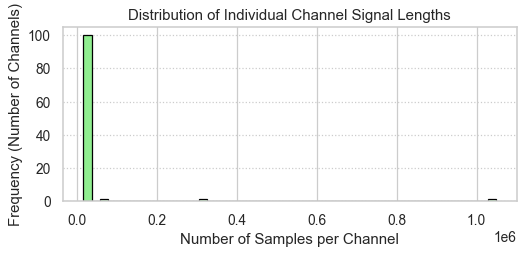

In [11]:
all_channel_signals_list = [] # List for tuples: (signal_1d_array, label, unique_id)
channel_signal_lengths = []

print("--- Loading & Expanding Signals (Channel-as-Sample) ---")
for filename_rel, label in INPUT_FILES_LABELS.items():
    filepath = os.path.join(DATA_DIR, filename_rel)
    print(f"Processing file: {filename_rel} (Label: {CLASS_NAMES[label]})")
    if not os.path.exists(filepath):
        print(f"  WARNING: File not found at {filepath}. Skipping.")
        continue
    try:
        # Load the entire file first, figure out header later
        df_full = pd.read_csv(filepath, header=None)
        header_row = None
        num_cols = df_full.shape[1]

        # Try to detect header by checking if first row is numeric
        try:
            pd.to_numeric(df_full.iloc[0]) # Check all columns in first row
            header_row = None
        except (ValueError, TypeError):
            header_row = 0
            print(f"  Potential header detected. Will reload skipping row 0.")
            # Reload skipping header
            df_full = pd.read_csv(filepath, header=header_row)
        except Exception: # Handle other potential errors during check
             header_row = None # Assume no header if check fails strangely

        print(f"  Loaded {df_full.shape[0]} rows, {num_cols} channels initially.")

        # Iterate through each column (channel)
        for col_idx in range(num_cols):
            # Extract the column
            # Use iloc for integer position based indexing, safer if headers are missing/present
            signal_1d_series = df_full.iloc[:, col_idx]

            # Create a unique ID for this channel signal
            unique_id = f"{filename_rel}_ch{col_idx}"

            # Convert to numeric, coerce errors, drop NaNs for this channel
            signal_1d_numeric = pd.to_numeric(signal_1d_series, errors='coerce')
            signal_1d_clean = signal_1d_numeric.dropna()

            if not signal_1d_clean.empty:
                signal_1d_array = signal_1d_clean.values # Get NumPy array (1D)
                all_channel_signals_list.append((signal_1d_array, label, unique_id))
                channel_signal_lengths.append(len(signal_1d_array))
                # print(f"    Added channel {col_idx} ({len(signal_1d_array)} samples) as a separate signal.") # Verbose
            else:
                print(f"    WARNING: Channel {col_idx} from {filename_rel} is empty or invalid after cleaning. Skipping this channel.")

    except pd.errors.EmptyDataError:
        print(f"  WARNING: File {filename_rel} is empty. Skipping.")
    except Exception as e:
        print(f"  ERROR loading or processing columns from {filename_rel}: {e}")

print("-" * 40)
print(f"Total individual channel signals loaded: {len(all_channel_signals_list)}")
if not all_channel_signals_list:
    raise ValueError("CRITICAL: No channel signals were loaded successfully.")

# --- Visualize Signal Lengths ---
plt.figure(figsize=(6, 3))
if channel_signal_lengths:
    plt.hist(channel_signal_lengths, bins=50, color='lightgreen', edgecolor='black') # More bins potentially
else:
    plt.text(0.5, 0.5, 'No data loaded', horizontalalignment='center', verticalalignment='center')
plt.title("Distribution of Individual Channel Signal Lengths")
plt.xlabel("Number of Samples per Channel")
plt.ylabel("Frequency (Number of Channels)")
plt.grid(True, axis='y', linestyle=':')
plt.tight_layout()
plt.show()

✂️ ## Train/Validation Split (on Individual Channels)

Split the **expanded list** of individual channel signals into training and validation sets using stratification. Now we have many more samples to split.

#5


--- Splitting 103 Channel Signals (20% Validation) ---
Using stratification seed: 42
Split complete:
  Training channel signals: 82
  Validation channel signals: 21


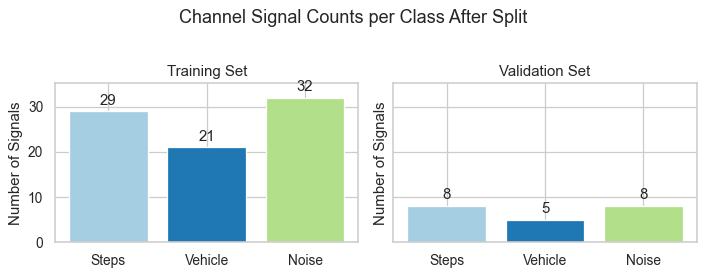

In [12]:
# Prepare lists for splitting from the expanded channel list
channel_data = [item[0] for item in all_channel_signals_list] # 1D signal arrays
channel_labels = [item[1] for item in all_channel_signals_list]
channel_ids = [item[2] for item in all_channel_signals_list] # Keep track of origin

print(f"\n--- Splitting {len(channel_data)} Channel Signals ({VALIDATION_SPLIT_RATIO*100:.0f}% Validation) ---")
print(f"Using stratification seed: {STRATIFY_SEED}")

# Check if stratification is possible
min_class_count = np.min(np.bincount(channel_labels)) if len(channel_labels) > 0 else 0
can_stratify = min_class_count >= 2

if not can_stratify and len(channel_labels) > 0:
     print(f"WARNING: Cannot stratify! Least populated class has {min_class_count} samples. Splitting without stratification.")

# Perform the split on indices
indices = list(range(len(channel_labels)))
train_indices, val_indices = train_test_split(
    indices,
    test_size=VALIDATION_SPLIT_RATIO,
    random_state=STRATIFY_SEED,
    stratify=channel_labels if can_stratify else None, # Stratify only if possible
    shuffle=True
)

# Create the final train/validation lists using the indices
# Each list will contain tuples of (signal_1d_array, label, unique_id)
train_signals_split = [all_channel_signals_list[i] for i in train_indices]
val_signals_split = [all_channel_signals_list[i] for i in val_indices]

print(f"Split complete:")
print(f"  Training channel signals: {len(train_signals_split)}")
print(f"  Validation channel signals: {len(val_signals_split)}")

# --- Visualize Post-Split Counts Per Class ---
train_split_labels = [item[1] for item in train_signals_split]
val_split_labels = [item[1] for item in val_signals_split]

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
fig.suptitle("Channel Signal Counts per Class After Split", y=1.02)
plot_split_counts(train_split_labels, "Training Set", axes[0]) # Reuse function from Helper cell
plot_split_counts(val_split_labels, "Validation Set", axes[1])
plt.tight_layout(); plt.show()

⚙️ ## Data Processing: Windowing & Feature Extraction (on Individual Channels)

Process the individual channel signals from the Training and Validation sets. Since each signal is already 1D, no padding or channel selection is needed.

1.  **Filter**: Apply bandpass filter.
2.  **Windowing**: Chop into `window_size` chunks.
3.  **Feature Extraction (Per Window)**:
    *   Calculate Spectrogram.
    *   Resize Spectrogram and make 3-channel.
    *   Calculate Statistical Features.
4.  **Store Features**: Collect features and labels for both sets.

- **`X_spec_train_raw`, `X_stat_train_raw`, `y_train_raw`**: Features/labels for training windows.
- **`X_spec_val`, `X_stat_val`, `y_val`**: Features/labels for validation windows.

📊 *Bar charts showing window counts per class will be displayed.*

#6


--- Processing Channel Signals for Training Set ---
 Proc channel 82/82 (car.csv_ch4)....)...
Finished processing Training:
  Total windows processed: 13854
  Total windows skipped: 0
  Skipped reasons: {'filter_short': 0, 'spec_none': 0, 'spec_resize': 0, 'stat_nan_inf': 0, 'stat_shape': 0, 'other_exception': 0}

--- Processing Channel Signals for Validation Set ---
 Proc channel 21/21 (nothing.csv_ch32)...
Finished processing Validation:
  Total windows processed: 2379
  Total windows skipped: 0
  Skipped reasons: {'filter_short': 0, 'spec_none': 0, 'spec_resize': 0, 'stat_nan_inf': 0, 'stat_shape': 0, 'other_exception': 0}
----------------------------------------
Processed Training:
 Specs: (13854, 3, 224, 224)
 Stats: (13854, 21)
 Labels: (13854,)

Processed Validation:
 Specs: (2379, 3, 224, 224)
 Stats: (2379, 21)
 Labels: (2379,)


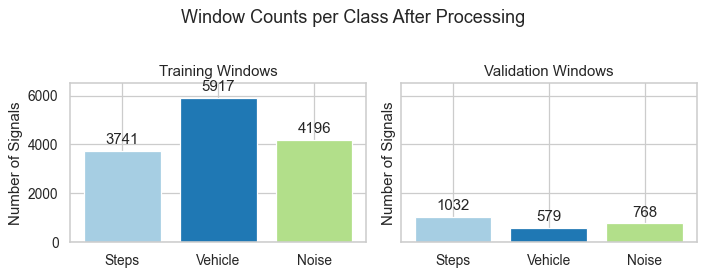

----------------------------------------


In [13]:
# <<< שימוש בפונקציה מעודכנת ללא padding/channel selection >>>
def process_channel_signals_split(signal_label_list, dataset_name=""):
    """Applies filtering, windowing, and feature extraction to 1D channel signals."""
    all_specs, all_stat_features, all_window_labels = [], [], []
    total_windows_processed = 0; skipped_windows = 0
    fail_reason_counts = {'filter_short': 0, 'spec_none': 0, 'spec_resize': 0, 'stat_nan_inf': 0, 'stat_shape': 0, 'other_exception': 0}

    print(f"\n--- Processing Channel Signals for {dataset_name} Set ---")
    if not signal_label_list: print("No signals."); return [], [], []

    num_signals = len(signal_label_list)
    for idx, (signal_1d_orig, label, channel_id) in enumerate(signal_label_list):
        print(f" Proc channel {idx+1}/{num_signals} ({channel_id})...", end='\r')

        # 1. Apply Filter to the 1D signal
        filtered_signal_1d = apply_filter(signal_1d_orig) # הפונקציה כבר מצפה ל-1D
        if len(filtered_signal_1d) < window_size:
             fail_reason_counts['filter_short'] += 1; skipped_windows += (len(filtered_signal_1d) // stride) if stride > 0 else 1; continue

        # 2. Create Windows (Function now expects 1D input)
        windows_1d, window_labels = create_windows(filtered_signal_1d, label) # windows_1d הם מערכי 1D
        if not windows_1d: continue

        # 3. Extract Features per Window
        for i, w_1d in enumerate(windows_1d): # w_1d is the 1D window
            try:
                # --- signal_1d is now w_1d ---
                spec = create_stft_spectrogram(w_1d, sr=fs, n_fft=N_FFT, hop_length=HOP_LENGTH)
                if spec is None: skipped_windows += 1; fail_reason_counts['spec_none'] += 1; continue
                try: resized_spec = cv2.resize(spec, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
                except Exception as resize_e: skipped_windows += 1; fail_reason_counts['spec_resize'] += 1; continue
                spec_3ch = np.stack([resized_spec] * 3, axis=0)
                stat_feats = extract_statistical_features(w_1d, sr=fs, n_mfcc=NUM_MFCC_FEATURES)
                is_nan_inf = np.isnan(stat_feats).any() or np.isinf(stat_feats).any()
                is_wrong_shape = stat_feats.shape[0] != NUM_STAT_FEATURES
                if is_nan_inf: skipped_windows += 1; fail_reason_counts['stat_nan_inf'] += 1; continue
                if is_wrong_shape: skipped_windows += 1; fail_reason_counts['stat_shape'] += 1; continue

                all_specs.append(spec_3ch); all_stat_features.append(stat_feats)
                all_window_labels.append(window_labels[i]); total_windows_processed += 1
            except Exception as e: skipped_windows += 1; fail_reason_counts['other_exception'] += 1; continue

    print(f"\nFinished processing {dataset_name}:")
    print(f"  Total windows processed: {total_windows_processed}")
    print(f"  Total windows skipped: {skipped_windows}")
    print(f"  Skipped reasons: {fail_reason_counts}")
    return (np.array(all_specs, dtype=np.float32),
            np.array(all_stat_features, dtype=np.float32),
            np.array(all_window_labels, dtype=np.int64))

# --- Process Training and Validation Channel Signals ---
X_spec_train_raw, X_stat_train_raw, y_train_raw = process_channel_signals_split(train_signals_split, "Training")
X_spec_val, X_stat_val, y_val = process_channel_signals_split(val_signals_split, "Validation")

print("-" * 40)
# --- Verify Shapes & Visualize Window Counts ---
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
fig.suptitle("Window Counts per Class After Processing", y=1.02)
if len(y_train_raw) > 0: print(f"Processed Training:\n Specs: {X_spec_train_raw.shape}\n Stats: {X_stat_train_raw.shape}\n Labels: {y_train_raw.shape}"); plot_split_counts(y_train_raw, "Training Windows", axes[0])
else: print("No training windows.")
if len(y_val) > 0: print(f"\nProcessed Validation:\n Specs: {X_spec_val.shape}\n Stats: {X_stat_val.shape}\n Labels: {y_val.shape}"); plot_split_counts(y_val, "Validation Windows", axes[1])
else: print("No validation windows.")
plt.tight_layout(); plt.show()
print("-" * 40)
if len(y_train_raw) == 0: raise ValueError("CRITICAL: No training windows generated.")

🖼️ ## Data Visualization: Sample Window & Spectrogram

Visualize a random sample window (spectrogram) from the **training set** (derived from an individual channel).

#7

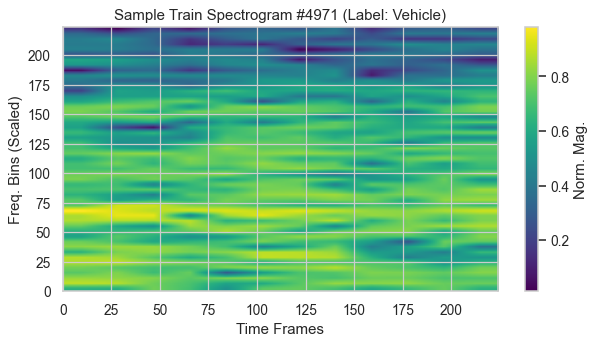

In [14]:
if len(y_train_raw) > 0:
    sample_idx = random.randint(0, len(y_train_raw) - 1)
    sample_spec_3ch = X_spec_train_raw[sample_idx]
    sample_label_idx = y_train_raw[sample_idx]
    sample_label_name = CLASS_NAMES[sample_label_idx]
    sample_spec_1ch = sample_spec_3ch[0, :, :] # Plot first channel

    plt.figure(figsize=(7, 4))
    plt.imshow(sample_spec_1ch, aspect='auto', origin='lower', cmap='viridis', extent=[0, IMG_WIDTH, 0, IMG_HEIGHT])
    plt.colorbar(label='Norm. Mag.')
    plt.title(f"Sample Train Spectrogram #{sample_idx} (Label: {sample_label_name})")
    plt.xlabel("Time Frames"); plt.ylabel("Freq. Bins (Scaled)")
    plt.tight_layout(); plt.show()
else: print("No training samples to visualize.")

⚖️ ## SMOTE and Feature Scaling

1.  Apply SMOTE to the **training set's statistical features**. Due to the large increase in samples from the channel expansion, **monitor for MemoryErrors**. If errors occur, consider the alternative approach (modifying the Dataset to sample spectrograms) mentioned previously. For now, we attempt the full duplication.
2.  Fit `StandardScaler` on the SMOTE-balanced training statistical features.
3.  Transform both training and validation statistical features.

📊 *A bar chart showing the window distribution *after* SMOTE will be displayed.*

#8

In [16]:
# --- WARNING: This cell is memory intensive due to spectrogram duplication ---
# --- If you encounter MemoryError, implement solution #5 from the earlier discussion ---
# --- (Keep original specs, modify HybridDataset.__getitem__ to sample specs) ---

print("\n--- Applying SMOTE to Training Statistical Features ---")
X_spec_train_balanced = X_spec_train_raw.copy(); X_stat_train_smote = X_stat_train_raw.copy(); y_train_smote = y_train_raw.copy()
min_samples = np.min(np.bincount(y_train_smote)) if len(y_train_smote) > 0 else 0
num_classes_present = len(np.unique(y_train_smote))

if min_samples > 1 and num_classes_present > 1:
    k = min(5, max(1, min_samples - 1)); print(f"Applying SMOTE with k_neighbors={k}")

    smote = SMOTE(random_state=STRATIFY_SEED, k_neighbors=k)
    try:
        X_stat_train_smote, y_train_smote = smote.fit_resample(X_stat_train_raw, y_train_raw)
        print(f" Shape after SMOTE - Stats: {X_stat_train_smote.shape}, Labels: {y_train_smote.shape}")
        num_orig = len(X_spec_train_raw); num_smote = len(y_train_smote)
        num_to_add = num_smote - num_orig

        if num_to_add > 0:
            print(f" Attempting to duplicate {num_to_add} spectrograms...")
            start_dup_time = time.time()
            # --- Memory Intensive Step ---
            duplicate_indices = np.random.choice(num_orig, size=num_to_add, replace=True)
            specs_to_add = X_spec_train_raw[duplicate_indices]
            X_spec_train_balanced = np.concatenate((X_spec_train_raw, specs_to_add), axis=0)
            # --- End Memory Intensive Step ---
            del specs_to_add, duplicate_indices # Free memory explicitly
            print(f" Spectrogram duplication took {time.time() - start_dup_time:.2f}s")

        elif num_smote < num_orig: print("Warning: SMOTE < original. Using original."); X_spec_train_balanced=X_spec_train_raw; X_stat_train_smote=X_stat_train_raw; y_train_smote=y_train_raw
        # Final check
        if len(X_spec_train_balanced)!=len(X_stat_train_smote) or len(X_spec_train_balanced)!=len(y_train_smote):
             print("CRITICAL WARNING: Mismatch after SMOTE! Attempting to fix by truncation.")
             min_len = min(len(X_spec_train_balanced), len(X_stat_train_smote), len(y_train_smote))
             X_spec_train_balanced=X_spec_train_balanced[:min_len]; X_stat_train_smote=X_stat_train_smote[:min_len]; y_train_smote=y_train_smote[:min_len]
             print(f" Truncated length: {min_len}")

    except MemoryError as me:
         print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
         print(f"MEMORY ERROR during spectrogram duplication: {me}")
         print(f"The dataset is too large ({num_to_add} duplicates) for available RAM.")
         print(f"Consider using the alternative sampling method in the HybridDataset")
         print(f"OR run on a machine with more RAM.")
         print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
         # Fallback to original data to allow script to potentially continue (though results will be affected)
         print("Falling back to using original imbalanced training data due to MemoryError.")
         X_spec_train_balanced = X_spec_train_raw
         X_stat_train_smote = X_stat_train_raw
         y_train_smote = y_train_raw
    except ValueError as e: print(f"SMOTE Error: {e}. Using original."); X_spec_train_balanced=X_spec_train_raw; X_stat_train_smote=X_stat_train_raw; y_train_smote=y_train_raw
else:
    reason = "minority class too small" if min_samples <= 1 else "only one class present"
    print(f"Skipping SMOTE: {reason}.")
    X_spec_train_balanced=X_spec_train_raw; X_stat_train_smote=X_stat_train_raw; y_train_smote=y_train_raw

print(f"\nFinal Training Set Size: {len(y_train_smote)} samples.")

# --- Plot Class Distribution AFTER SMOTE (or original if SMOTE failed/skipped) ---
plt.figure(figsize=(5, 3))
ax = plt.gca()
plot_split_counts(y_train_smote, "Training Distribution (Attempted SMOTE)", ax)
plt.tight_layout(); plt.show()

# --- Scale Statistical Features ---
print("\n--- Scaling Statistical Features ---")
scaler = StandardScaler()
print("Fitting Scaler on Training Features..."); X_stat_train_scaled = scaler.fit_transform(X_stat_train_smote)
print("Transforming Validation Features...")
if len(X_stat_val) > 0: X_stat_val_scaled = scaler.transform(X_stat_val); print(" Validation data scaled.")
else: X_stat_val_scaled = np.array([]); print(" No validation data to scale.")
scaler_filepath = os.path.join(SAVE_PATH_BASE, "scaler.pkl");
try: pickle.dump(scaler, open(scaler_filepath, 'wb')); print(f"Scaler saved: {scaler_filepath}")
except Exception as e: print(f"Error saving scaler: {e}")
print("-" * 40)


--- Applying SMOTE to Training Statistical Features ---


MemoryError: Unable to allocate 7.77 GiB for an array with shape (13854, 3, 224, 224) and data type float32

📦 ## PyTorch Dataset and DataLoader

Create `Dataset` and `DataLoader` instances. **If SMOTE failed due to memory**, the training set will use the original imbalanced data.

#9

In [ ]:
print("\n--- Creating PyTorch Datasets and DataLoaders ---")
imagenet_mean=[0.485, 0.456, 0.406]; imagenet_std=[0.229, 0.224, 0.225] # Use ImageNet stats for MobileNet too
val_transforms = transforms.Compose([transforms.Normalize(mean=imagenet_mean, std=imagenet_std)])
train_transforms_list = []
if BEST_PARAMS["specaug_apply"]: print("Applying SpecAugment."); train_transforms_list.append(SpecAugment(freq_mask_param=BEST_PARAMS["specaug_freq_mask"], time_mask_param=BEST_PARAMS["specaug_time_mask"], num_freq_masks=BEST_PARAMS["specaug_f_masks"], num_time_masks=BEST_PARAMS["specaug_t_masks"]))
else: print("SpecAugment disabled.")
train_transforms_list.append(transforms.Normalize(mean=imagenet_mean, std=imagenet_std))
train_transforms = transforms.Compose(train_transforms_list)
try:
    if len(y_train_smote) == 0: raise ValueError("No training data.") # Check the label array after SMOTE attempt
    # Use the potentially balanced spec array and the scaled stats array
    train_dataset = HybridDataset(specs=X_spec_train_balanced, stat_feats=X_stat_train_scaled, labels=y_train_smote, transform=train_transforms, add_noise=BEST_PARAMS["add_stat_noise"], noise_std=BEST_PARAMS["stat_feature_noise_std"])
    print(f"Train Dataset: {len(train_dataset)} samples.")
    if len(y_val) > 0: val_dataset = HybridDataset(specs=X_spec_val, stat_feats=X_stat_val_scaled, labels=y_val, transform=val_transforms, add_noise=False); print(f"Validation Dataset: {len(val_dataset)} samples.")
    else: val_dataset = None; print("No validation dataset.")
except Exception as e: raise ValueError(f"Failed dataset creation: {e}") from e

train_loader = DataLoader(train_dataset, batch_size=FINAL_BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False, drop_last=(len(train_dataset) > FINAL_BATCH_SIZE))
print(f"Train DataLoader created.")
if val_dataset: val_loader = DataLoader(val_dataset, batch_size=FINAL_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False, drop_last=False); print(f"Validation DataLoader created.")
else: val_loader = None; print("Validation DataLoader not created.")
print("-" * 40)

🧠 ## Model, Optimizer, Loss Setup

Instantiate the **LightweightHybridModel** (using MobileNetV3-Small), define loss (with class weights based on the **post-SMOTE attempt** training distribution), optimizer, and LR scheduler.

#10

print("\n--- Setting up Lightweight Model, Optimizer, and Loss ---")

# --- Instantiate the Lightweight Model ---
model = LightweightHybridModel( # <<< שימוש במודל הקל
    num_classes=NUM_CLASSES,
    dropout_p=BEST_PARAMS["dropout_p"], # Using potentially adjusted dropout from params
    input_stat_features=NUM_STAT_FEATURES,
    stat_feature_dim=BEST_PARAMS["stat_dim"], # Using potentially adjusted dims
    combined_dim=BEST_PARAMS["comb_dim"]
).to(device)

print(f"Model Instantiated: {model.__class__.__name__}")

# --- Calculate Class Weights for Loss Function ---
# Based on the training labels *after* the SMOTE attempt (y_train_smote)
if len(y_train_smote) > 0:
    class_counts = np.maximum(np.bincount(y_train_smote, minlength=NUM_CLASSES), 1)
    total_samples = class_counts.sum()
    class_weights = total_samples / (NUM_CLASSES * class_counts)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(f"Using Class Weights: {class_weights_tensor.cpu().numpy()}") # Will reflect imbalance if SMOTE failed
else:
    class_weights_tensor = None
    print("No training data for weight calculation.")

# --- Define Loss Function ---
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=BEST_PARAMS["label_smoothing"]
)
print(f"Loss Function: CrossEntropyLoss (LS: {BEST_PARAMS['label_smoothing']:.1e})")

# --- Define Optimizer ---
optimizer = optim.AdamW(
    model.parameters(),
    lr=BEST_PARAMS["lr"],
    weight_decay=BEST_PARAMS["weight_decay"]
)
print(f"Optimizer: AdamW (LR: {BEST_PARAMS['lr']:.1e}, WD: {BEST_PARAMS['weight_decay']:.1e})")

# --- Define Learning Rate Scheduler ---
scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=False
)
print(f"LR Scheduler: ReduceLROnPlateau (Factor: {SCHEDULER_FACTOR}, Patience: {SCHEDULER_PATIENCE})")
print("-" * 40)

🏋️ ## Model Training (Lightweight Model)

Execute the training loop for the lightweight model. Expect epochs to potentially take **longer** due to the increased number of training windows (if SMOTE succeeded).

#11

# This cell should work as is from the previous versions.
# It will use the `model`, `train_loader`, `val_loader`, etc. defined above.
print("\n--- Starting Model Training (Lightweight Model) ---")
best_val_loss = float('inf'); best_epoch = -1; epochs_no_improve = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
final_model_save_path = os.path.join(SAVE_PATH_BASE, f"{RUN_NAME}_best_model.pth")
start_time_training = time.time()
# (Paste the exact training loop code from previous answer's Code Block #11 here)
for epoch in range(1, FINAL_EPOCHS + 1):
    epoch_start_time = time.time()
    train_loss, train_acc = train_epoch_hybrid(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    val_loss, val_acc = None, None
    if val_loader:
        val_loss, val_acc, _, _ = evaluate_model_hybrid(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
    else: history['val_loss'].append(None); history['val_acc'].append(None)
    epoch_duration = time.time() - epoch_start_time
    log_msg = f"Epoch {epoch:03d} [{epoch_duration:.1f}s] Tr L={train_loss:.4f} A={train_acc:.4f}"
    save_model_flag = False
    if val_loader and val_loss is not None:
        log_msg += f" | Val L={val_loss:.4f} A={val_acc:.4f}"
        scheduler.step(val_loss) # Step scheduler on validation loss
        if val_loss < best_val_loss:
             log_msg += f" *Imprv"
             best_val_loss = val_loss; best_epoch = epoch; epochs_no_improve = 0; save_model_flag = True
        else: epochs_no_improve += 1; log_msg += f" ({epochs_no_improve}/{FINAL_PATIENCE})"
    print(log_msg + f" | LR={optimizer.param_groups[0]['lr']:.1e}") # Print LR at end
    if save_model_flag: save_final_model(epoch, model, optimizer, scaler, val_loss, val_acc, BEST_PARAMS, final_model_save_path)
    if val_loader and epochs_no_improve >= FINAL_PATIENCE: print(f"\nEarly stopping @ Epoch {epoch}."); break
    if not val_loader and epoch >= FINAL_EPOCHS: print(f"\nMax epochs reached (no validation).")
total_training_time = time.time() - start_time_training
print(f"\n--- Training Finished ({total_training_time / 60:.2f} min) ---")
if best_epoch != -1: print(f"Best Val Loss: {best_val_loss:.4f} @ Epoch {best_epoch}. Model saved: {final_model_save_path}")
else: print("No best model saved (or no validation).")
print("-" * 40)

📈 ## Training History Visualization

#12

In [ ]:
# This cell should work as is from the previous versions.
plot_training_history(history, SAVE_PATH_BASE, prefix="final_light_") # Changed prefix slightly

🧪 ## Final Model Evaluation (Lightweight Model)

Load the best **LightweightHybridModel** checkpoint and evaluate its performance on the held-out validation set.

#13

In [ ]:
print("\n--- Final Lightweight Model Evaluation on Held-Out Validation Set ---")
model_loaded = False
# Reuse the variable holding the path to the saved model
model_path_to_load = final_model_save_path

if best_epoch != -1 and os.path.exists(model_path_to_load):
    print(f"Loading best lightweight model: {model_path_to_load}")
    try:
        # Use weights_only=False as it contains scaler info
        checkpoint = torch.load(model_path_to_load, map_location=device, weights_only=False)

        # Load Scaler (same as before)
        eval_scaler = StandardScaler(); eval_scaler.mean_ = checkpoint['scaler_params']['mean']; eval_scaler.scale_ = checkpoint['scaler_params']['scale']
        eval_scaler.n_features_in_ = checkpoint['scaler_params']['n_features']; eval_scaler.n_samples_seen_ = checkpoint['scaler_params']['n_samples']
        assert eval_scaler.n_features_in_ == NUM_STAT_FEATURES, "Scaler mismatch"
        print("Scaler loaded.")

        # <<< Load Lightweight Model >>>
        eval_params = checkpoint.get('best_optuna_params', BEST_PARAMS)
        eval_model = LightweightHybridModel( # <<< ודא שאתה טוען את סוג המודל הנכון
            num_classes=NUM_CLASSES,
            dropout_p=eval_params.get('dropout_p', BEST_PARAMS["dropout_p"]),
            input_stat_features=eval_scaler.n_features_in_,
            stat_feature_dim=eval_params.get('stat_dim', BEST_PARAMS["stat_dim"]),
            combined_dim=eval_params.get('comb_dim', BEST_PARAMS["comb_dim"])
        ).to(device)
        eval_model.load_state_dict(checkpoint['model_state_dict'])
        eval_model.eval(); model_loaded = True; print("Lightweight Model state loaded.")

    except Exception as e: print(f"ERROR loading checkpoint: {e}")
else: print(f"Skipping evaluation: Best model checkpoint not found at {model_path_to_load} or was not saved.")

# --- Evaluate on the val_loader ---
if model_loaded and val_loader:
    print(f"\nEvaluating on Validation Set ({len(val_dataset)} samples)...")
    _, _, true_labels_np, pred_labels_np = evaluate_model_hybrid(eval_model, val_loader, None, device, is_final_eval=True)
    display_results(true_labels_np, pred_labels_np, "ValidationSet", SAVE_PATH_BASE, prefix="final_light_eval_")
elif model_loaded and not val_loader: print("\nNo validation data/loader was created during setup to evaluate.")
else: print("\nSkipping validation set evaluation as model was not loaded.")

print("\n=== Full Lightweight Model Notebook Finished ===")